In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import random
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

device

device(type='cuda', index=0)

In [2]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        label = self.labels_df.iloc[idx, 2] if 'Labels' in self.labels_df.columns else -1
        label = label.astype(np.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
batch_size = 8

In [4]:
# Data augmentation and normalization for training
scale_factor = 16
width = int(6000/scale_factor)
height = int(4000/scale_factor)
transform = transforms.Compose([
    transforms.Resize((height,width)),
    #transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomCrop(224, padding=4),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#width = 224
#height = 224

In [5]:
train_dataset = CustomDataset(csv_file='train.csv', img_dir='images/kaggle/working/Reorganized_Data/images', transform=transform)
#test_dataset = CustomDataset(csv_file='/kaggle/input/computer-vision-xm/test.csv', img_dir='/kaggle/input/computer-vision-xm/images/kaggle/working/Reorganized_Data/images', transform=transform)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


In [6]:
def get_gpu_dataloader(dataset,batch_size=1,shuffle=False):
    data = []
    labels = []
    for img, label in tqdm(dataset):
        data.append(img)
        labels.append(label)

    data = torch.stack(data)
    labels = torch.tensor(labels)

    data = data.to(device)
    labels = labels.to(device)

    loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(data, labels),
    batch_size=batch_size, shuffle=shuffle)
    return loader

In [7]:
# Create data loaders
train_loader = get_gpu_dataloader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = get_gpu_dataloader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = get_gpu_dataloader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 678/678 [00:54<00:00, 12.46it/s]


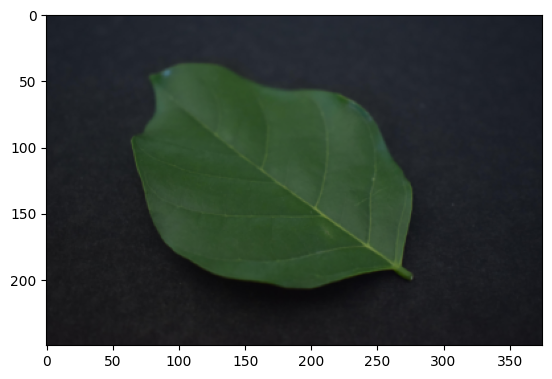

0.0


In [8]:
import torchvision.utils

import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataset)
next(dataiter)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)

In [39]:
class CNN(nn.Module):
    def __init__(self, num_classes=1):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 128, kernel_size=9, padding=4),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 64, kernel_size=15, padding=7),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),


            nn.Conv2d(64, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(32 * int(width/(2**4)) * int(height/(2**4)), 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x.reshape(-1)
    
model = CNN()
model = model.to(device)

In [40]:
# Calculate the total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# Move the model to GPU if available
print(device)
model.to(device)

# Training loop with early stopping
epochs = 100
patience = 10
best_val_loss = float('inf')
best_val_acc = 0
patience_counter = 0

for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training"):
        #images, labels = images.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.detach().item()

        # Backward pass
        loss.backward()
        optimizer.step()

    print(f'Training loss: {running_loss / len(train_loader)}')
    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation"):
            #images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Convert the outputs to predicted class labels
            predicted = (outputs>0.5).float() #torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    print(f'Validation loss: {val_loss / len(val_loader)}')
    print(f'Validation accuracy: {val_accuracy:.4f}')

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        patience_counter = patience_counter - 1 if patience_counter > 0 else 0
        torch.save(model.state_dict(), 'best_acc_model.pth')
        print(f'Best model saved with valid acc of {val_accuracy:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_val_model.pth')
        print(f'Best model saved with valid loss of {val_loss / len(val_loader)}')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


Total number of parameters: 8240545
cuda:0
Epoch 1/100


Training: 100%|██████████| 271/271 [00:04<00:00, 62.40it/s]


Training loss: 0.5422791421853308


Validation: 100%|██████████| 68/68 [00:00<00:00, 188.69it/s]


Validation loss: 0.40596769684377837
Validation accuracy: 0.8339
Best model saved with valid acc of 0.8339
Best model saved with valid loss of 0.40596769684377837
Epoch 2/100


Training: 100%|██████████| 271/271 [00:04<00:00, 64.82it/s]


Training loss: 0.3724547874636096


Validation: 100%|██████████| 68/68 [00:00<00:00, 189.60it/s]


Validation loss: 0.3044377707410604
Validation accuracy: 0.8690
Best model saved with valid acc of 0.8690
Best model saved with valid loss of 0.3044377707410604
Epoch 3/100


Training: 100%|██████████| 271/271 [00:04<00:00, 66.79it/s]


Training loss: 0.3036915170668016


Validation: 100%|██████████| 68/68 [00:00<00:00, 198.48it/s]


Validation loss: 0.23558883670279207
Validation accuracy: 0.9170
Best model saved with valid acc of 0.9170
Best model saved with valid loss of 0.23558883670279207
Epoch 4/100


Training: 100%|██████████| 271/271 [00:04<00:00, 67.08it/s]


Training loss: 0.2631749307420586


Validation: 100%|██████████| 68/68 [00:00<00:00, 189.83it/s]


Validation loss: 0.19841809472178712
Validation accuracy: 0.9170
Best model saved with valid loss of 0.19841809472178712
Epoch 5/100


Training: 100%|██████████| 271/271 [00:04<00:00, 64.65it/s]


Training loss: 0.22541645624953222


Validation: 100%|██████████| 68/68 [00:00<00:00, 189.06it/s]


Validation loss: 0.20910316842834137
Validation accuracy: 0.9151
Epoch 6/100


Training: 100%|██████████| 271/271 [00:04<00:00, 64.77it/s]


Training loss: 0.18473339134765396


Validation: 100%|██████████| 68/68 [00:00<00:00, 192.83it/s]


Validation loss: 0.2067060561179567
Validation accuracy: 0.9262
Best model saved with valid acc of 0.9262
Epoch 7/100


Training: 100%|██████████| 271/271 [00:04<00:00, 65.68it/s]


Training loss: 0.18219954022154816


Validation: 100%|██████████| 68/68 [00:00<00:00, 195.42it/s]


Validation loss: 0.20856865433126906
Validation accuracy: 0.9225
Epoch 8/100


Training: 100%|██████████| 271/271 [00:04<00:00, 66.48it/s]


Training loss: 0.1585159202508381


Validation: 100%|██████████| 68/68 [00:00<00:00, 194.34it/s]


Validation loss: 0.18493276083951488
Validation accuracy: 0.9299
Best model saved with valid acc of 0.9299
Best model saved with valid loss of 0.18493276083951488
Epoch 9/100


Training: 100%|██████████| 271/271 [00:04<00:00, 65.15it/s]


Training loss: 0.14867968817939123


Validation: 100%|██████████| 68/68 [00:00<00:00, 190.15it/s]


Validation loss: 0.3083137441152597
Validation accuracy: 0.8653
Epoch 10/100


Training: 100%|██████████| 271/271 [00:04<00:00, 64.50it/s]


Training loss: 0.13982845574589034


Validation: 100%|██████████| 68/68 [00:00<00:00, 190.44it/s]


Validation loss: 0.1718144020466271
Validation accuracy: 0.9391
Best model saved with valid acc of 0.9391
Best model saved with valid loss of 0.1718144020466271
Epoch 11/100


Training: 100%|██████████| 271/271 [00:04<00:00, 64.70it/s]


Training loss: 0.11750811785442335


Validation: 100%|██████████| 68/68 [00:00<00:00, 188.00it/s]


Validation loss: 0.16710975565194316
Validation accuracy: 0.9428
Best model saved with valid acc of 0.9428
Best model saved with valid loss of 0.16710975565194316
Epoch 12/100


Training: 100%|██████████| 271/271 [00:04<00:00, 64.80it/s]


Training loss: 0.10202017766887467


Validation: 100%|██████████| 68/68 [00:00<00:00, 189.40it/s]


Validation loss: 0.137108288529014
Validation accuracy: 0.9446
Best model saved with valid acc of 0.9446
Best model saved with valid loss of 0.137108288529014
Epoch 13/100


Training: 100%|██████████| 271/271 [00:04<00:00, 64.71it/s]


Training loss: 0.10031337107777015


Validation: 100%|██████████| 68/68 [00:00<00:00, 188.43it/s]


Validation loss: 0.16214804092476912
Validation accuracy: 0.9336
Epoch 14/100


Training: 100%|██████████| 271/271 [00:04<00:00, 64.78it/s]


Training loss: 0.10506060932087626


Validation: 100%|██████████| 68/68 [00:00<00:00, 189.51it/s]


Validation loss: 0.1824992242447265
Validation accuracy: 0.9299
Epoch 15/100


Training: 100%|██████████| 271/271 [00:04<00:00, 64.99it/s]


Training loss: 0.08493251090520706


Validation: 100%|██████████| 68/68 [00:00<00:00, 188.14it/s]


Validation loss: 0.3266432848741876
Validation accuracy: 0.9022
Epoch 16/100


Training: 100%|██████████| 271/271 [00:04<00:00, 64.93it/s]


Training loss: 0.08587083578007931


Validation: 100%|██████████| 68/68 [00:00<00:00, 191.08it/s]


Validation loss: 0.16357592252418673
Validation accuracy: 0.9391
Epoch 17/100


Training: 100%|██████████| 271/271 [00:04<00:00, 65.03it/s]


Training loss: 0.07337640594942126


Validation: 100%|██████████| 68/68 [00:00<00:00, 189.31it/s]


Validation loss: 0.2052287901768817
Validation accuracy: 0.9410
Epoch 18/100


Training: 100%|██████████| 271/271 [00:04<00:00, 65.04it/s]


Training loss: 0.07567523511324672


Validation: 100%|██████████| 68/68 [00:00<00:00, 189.76it/s]


Validation loss: 0.1759996344044339
Validation accuracy: 0.9557
Best model saved with valid acc of 0.9557
Epoch 19/100


Training: 100%|██████████| 271/271 [00:04<00:00, 64.61it/s]


Training loss: 0.055875219364716566


Validation: 100%|██████████| 68/68 [00:00<00:00, 189.36it/s]


Validation loss: 0.20961088480779674
Validation accuracy: 0.9299
Epoch 20/100


Training: 100%|██████████| 271/271 [00:04<00:00, 64.77it/s]


Training loss: 0.08165501865613473


Validation: 100%|██████████| 68/68 [00:00<00:00, 190.47it/s]


Validation loss: 0.26016405727641007
Validation accuracy: 0.9354
Epoch 21/100


Training: 100%|██████████| 271/271 [00:04<00:00, 65.17it/s]


Training loss: 0.05736272239939884


Validation: 100%|██████████| 68/68 [00:00<00:00, 188.59it/s]


Validation loss: 0.2746635820077138
Validation accuracy: 0.9354
Epoch 22/100


Training: 100%|██████████| 271/271 [00:04<00:00, 67.16it/s]


Training loss: 0.06463724448481133


Validation: 100%|██████████| 68/68 [00:00<00:00, 202.38it/s]


Validation loss: 0.14011988661984695
Validation accuracy: 0.9631
Best model saved with valid acc of 0.9631
Epoch 23/100


Training: 100%|██████████| 271/271 [00:04<00:00, 65.68it/s]


Training loss: 0.029404931612072447


Validation: 100%|██████████| 68/68 [00:00<00:00, 188.82it/s]


Validation loss: 0.1579718233024323
Validation accuracy: 0.9539
Epoch 24/100


Training: 100%|██████████| 271/271 [00:04<00:00, 64.88it/s]


Training loss: 0.051443116368117076


Validation: 100%|██████████| 68/68 [00:00<00:00, 190.39it/s]

Validation loss: 0.15881211576331278
Validation accuracy: 0.9539
Early stopping triggered


In [41]:
model.load_state_dict(torch.load('best_val_model.pth'))
model.to(device)

# Make predictions on the test dataset
model.eval()
predictions = []
labels = []
with torch.no_grad():
    for images, label in test_loader:
        images = images.to(device)
        outputs = model(images)
        predicted = (outputs>0.5).float()
        labels.extend(label.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Create a DataFrame with IDs and predictions
submission_df = pd.DataFrame({
    #'images': test_dataset.labels_df['Images'],
    'labels': predictions,
    'groundtruth': labels
})
#submission_df.to_csv('submission.csv', index=False)
#print('Submission file was created.')
submission_df

labels  groundtruth
0       1.0          0.0
1       1.0          1.0
2       1.0          1.0
3       0.0          0.0
4       0.0          0.0
..      ...          ...
673     1.0          1.0
674     1.0          1.0
675     1.0          1.0
676     0.0          0.0
677     0.0          0.0

[678 rows x 2 columns]

In [42]:
(submission_df.labels == submission_df.groundtruth).mean()

np.float64(0.9528023598820059)

In [43]:
wrong_assesments = submission_df[submission_df.labels != submission_df.groundtruth]
false_positives = len(wrong_assesments[wrong_assesments.groundtruth == 1])
false_negatives = len(wrong_assesments[wrong_assesments.groundtruth == 0])
print(f"We have {false_positives} false positives and {false_negatives} false negatives!")

We have 18 false positives and 14 false negatives!


False negative - Healthy plant classified as sick:


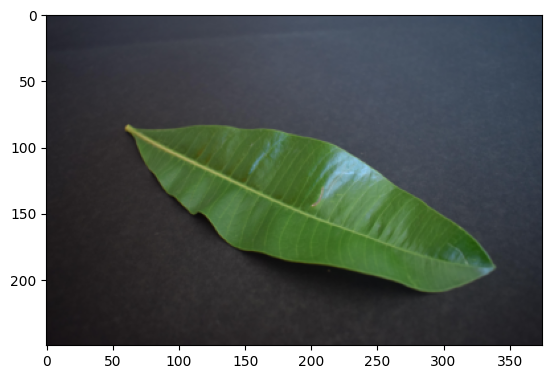

False negative - Healthy plant classified as sick:


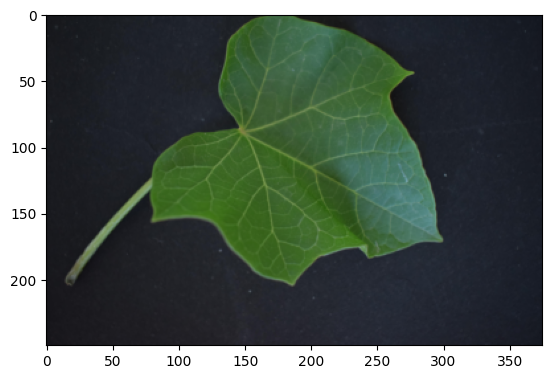

False negative - Healthy plant classified as sick:


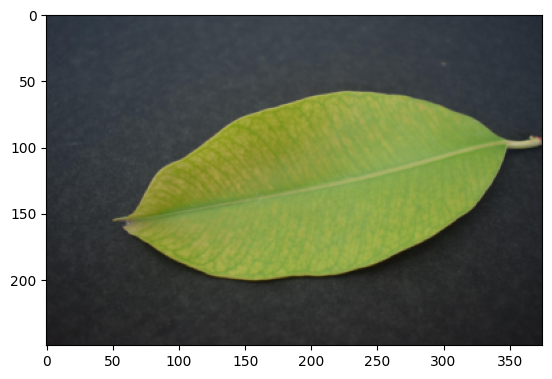

False positive - Sick plant classified as healthy:


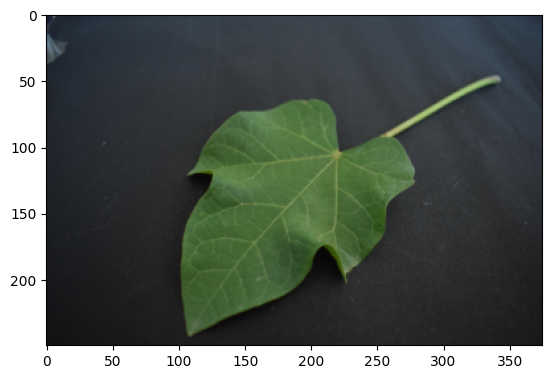

False positive - Sick plant classified as healthy:


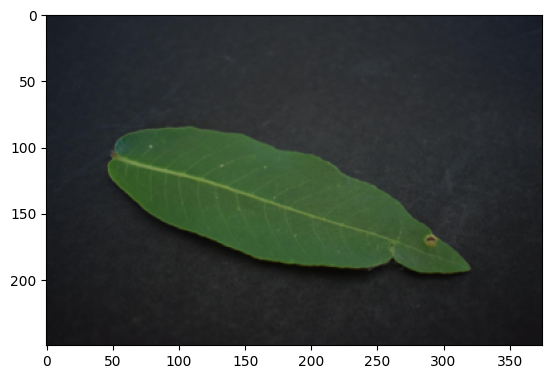

False negative - Healthy plant classified as sick:


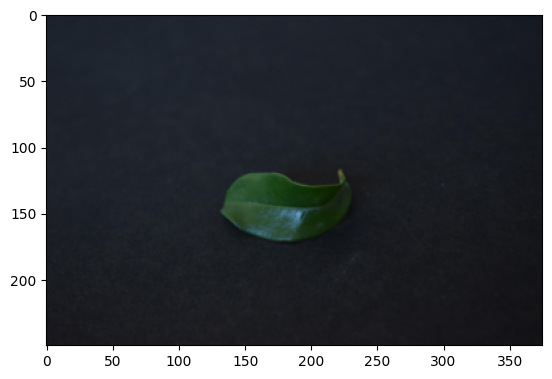

False negative - Healthy plant classified as sick:


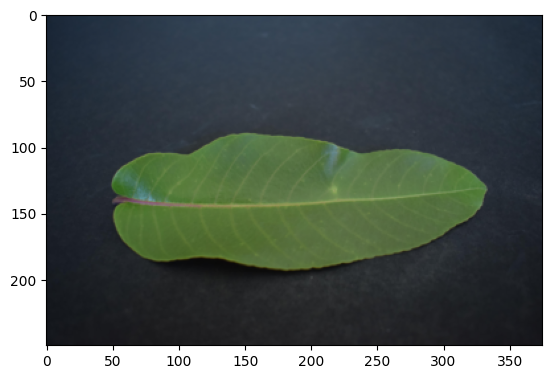

False positive - Sick plant classified as healthy:


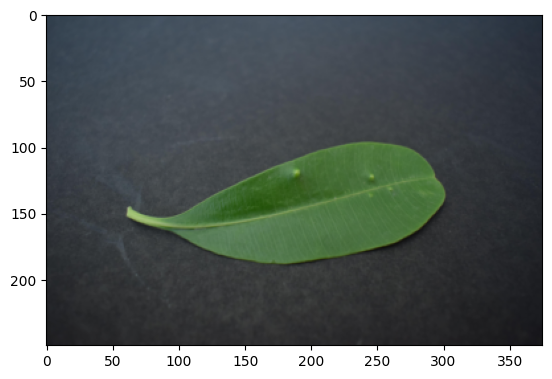

False positive - Sick plant classified as healthy:


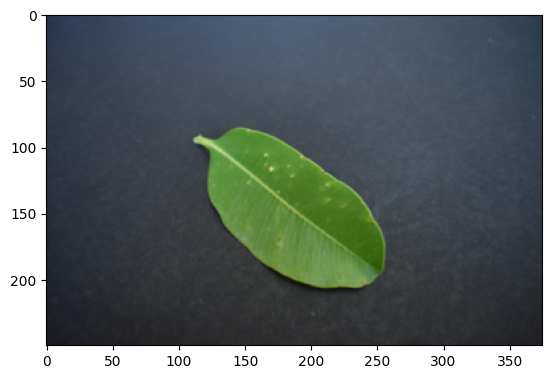

False positive - Sick plant classified as healthy:


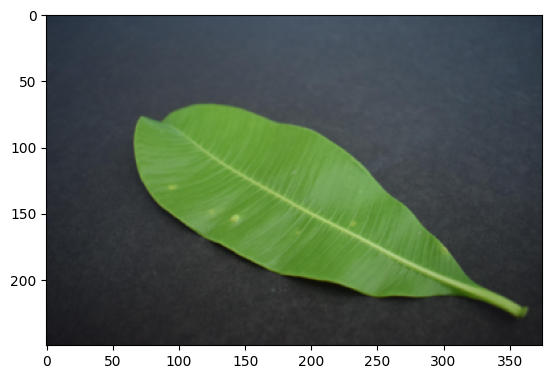

False positive - Sick plant classified as healthy:


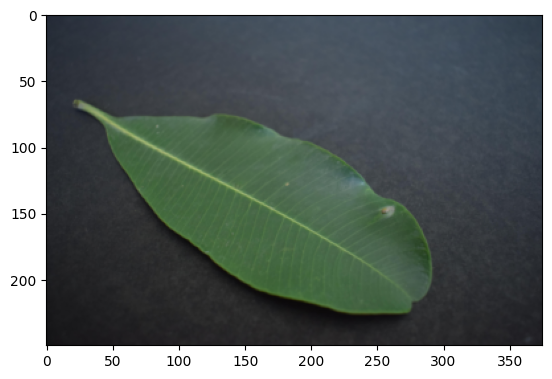

False positive - Sick plant classified as healthy:


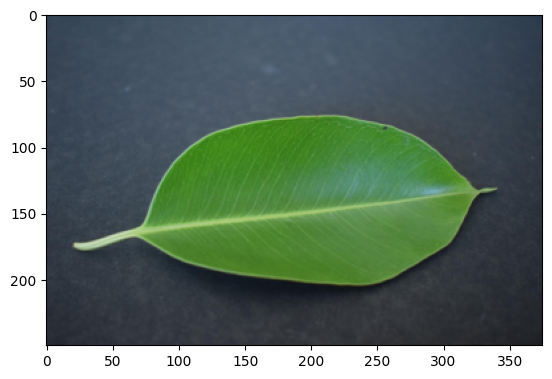

False negative - Healthy plant classified as sick:


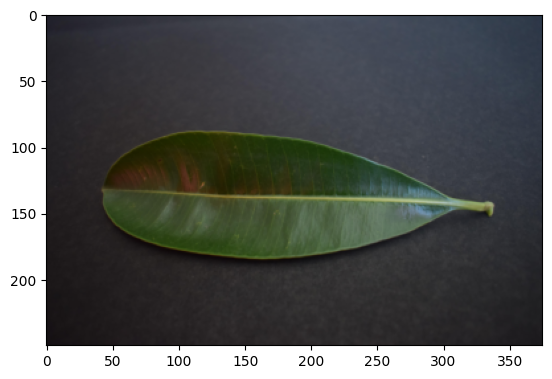

False negative - Healthy plant classified as sick:


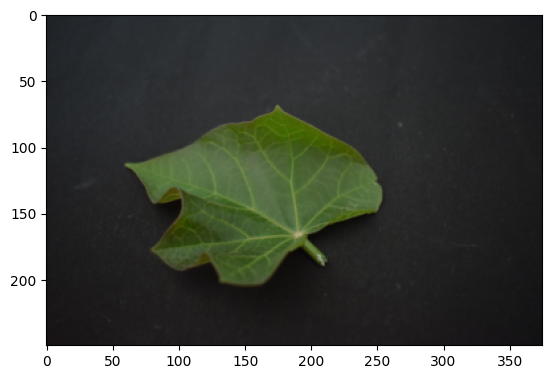

False negative - Healthy plant classified as sick:


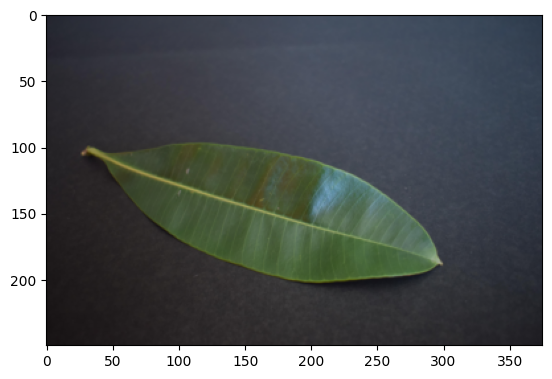

False positive - Sick plant classified as healthy:


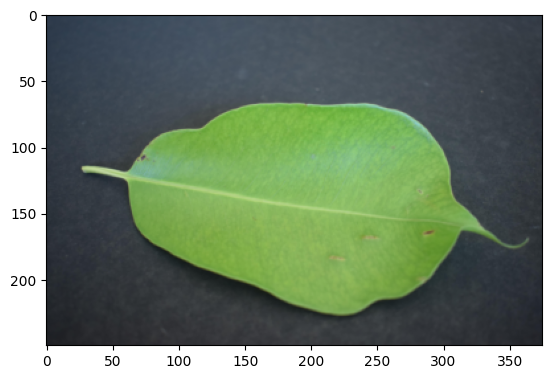

False negative - Healthy plant classified as sick:


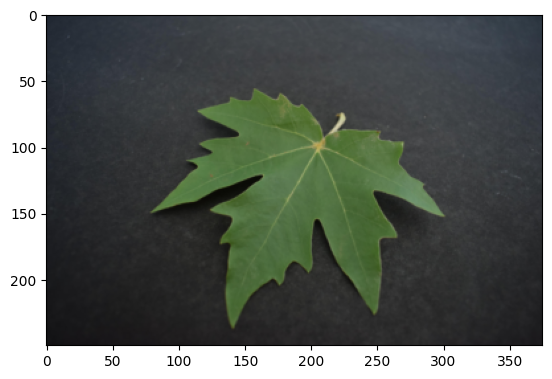

False positive - Sick plant classified as healthy:


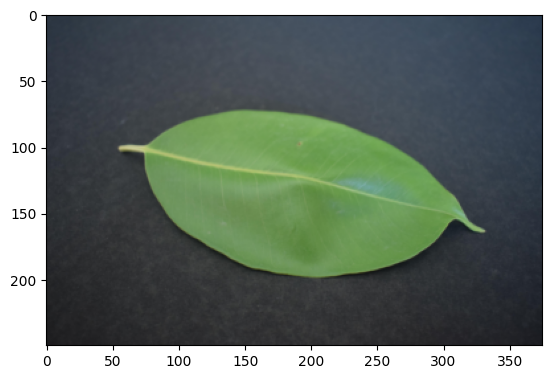

False positive - Sick plant classified as healthy:


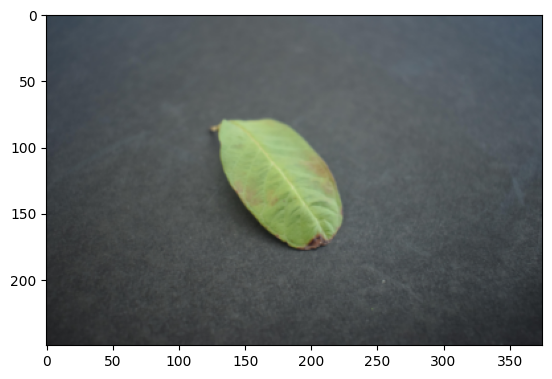

False positive - Sick plant classified as healthy:


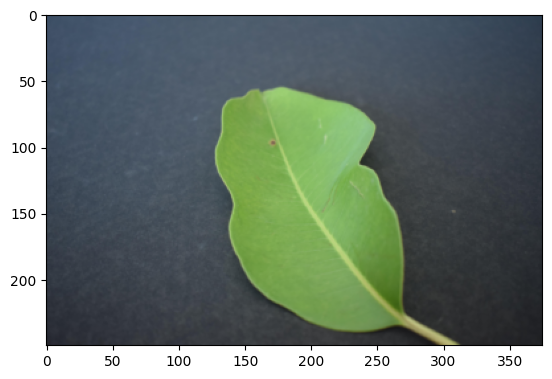

False negative - Healthy plant classified as sick:


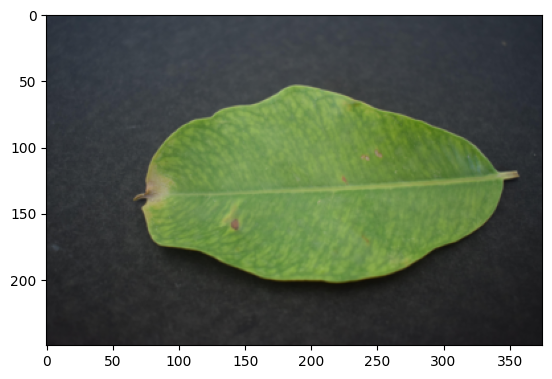

False positive - Sick plant classified as healthy:


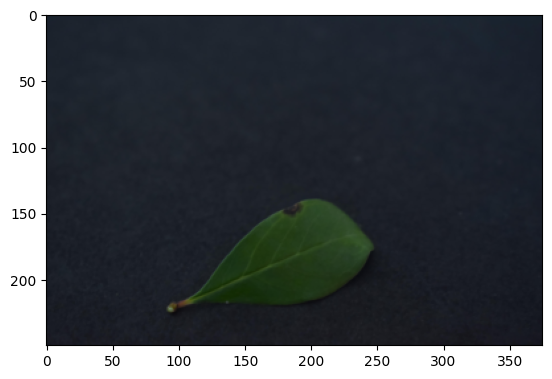

False positive - Sick plant classified as healthy:


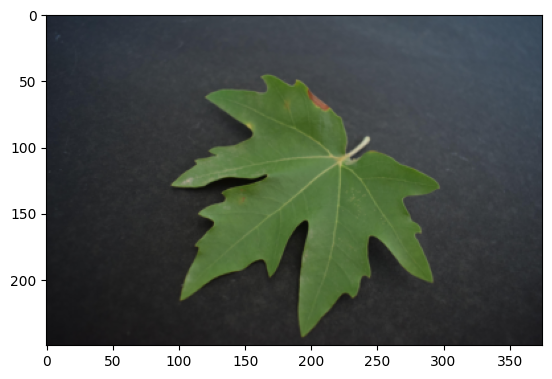

False positive - Sick plant classified as healthy:


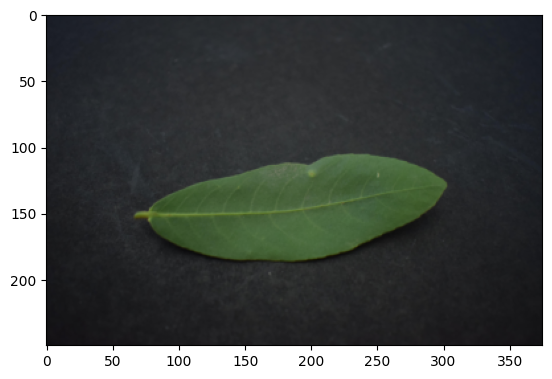

False positive - Sick plant classified as healthy:


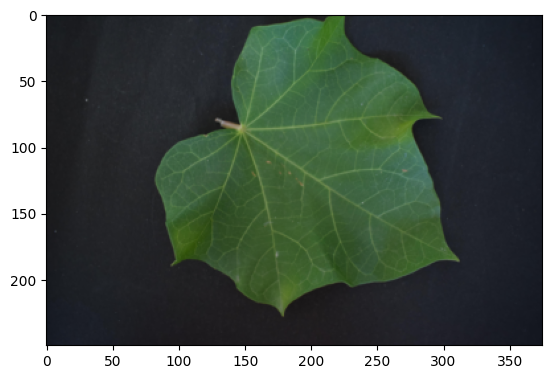

False negative - Healthy plant classified as sick:


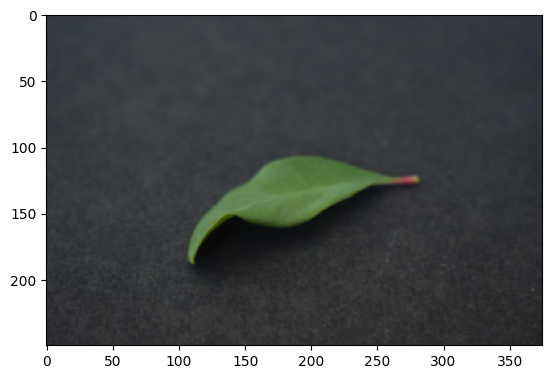

False negative - Healthy plant classified as sick:


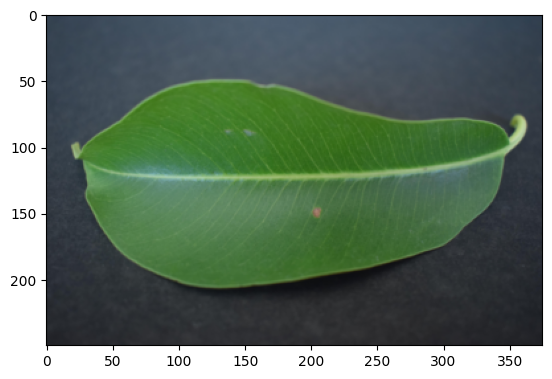

False positive - Sick plant classified as healthy:


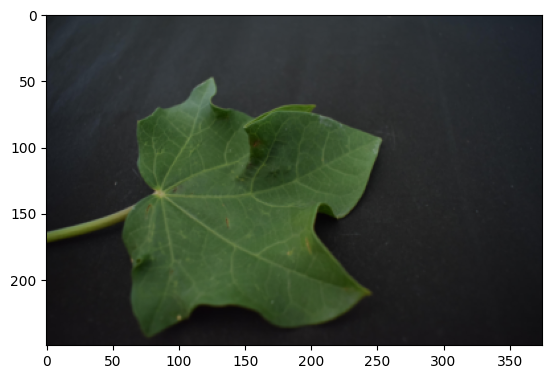

False positive - Sick plant classified as healthy:


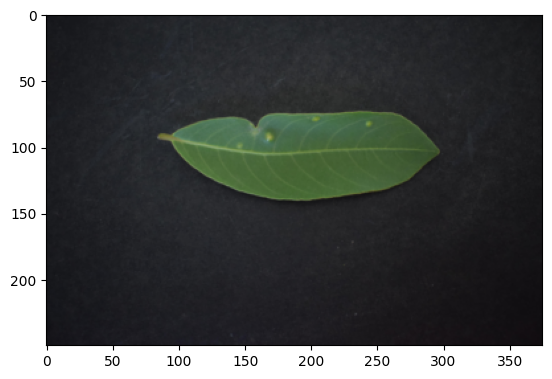

False negative - Healthy plant classified as sick:


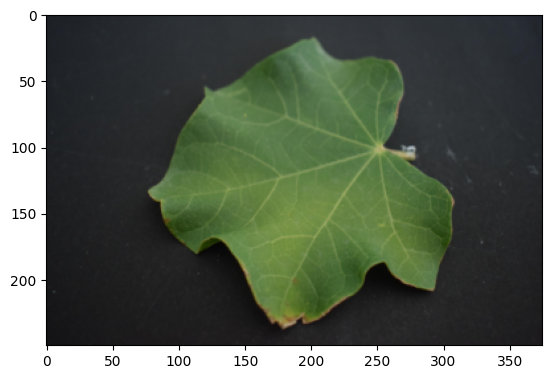

False positive - Sick plant classified as healthy:


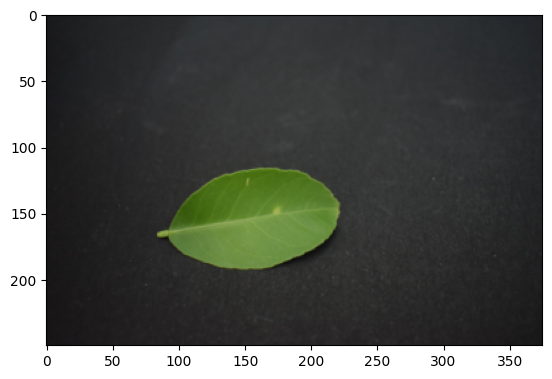

False negative - Healthy plant classified as sick:


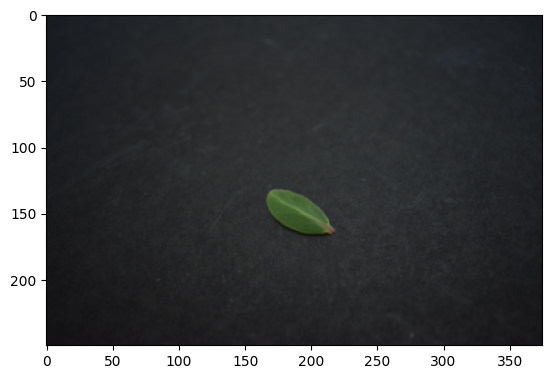

In [44]:
images = []
for idx, pred, truth in zip(wrong_assesments.index, wrong_assesments["labels"], wrong_assesments["groundtruth"]):
    if truth == 1:
        print("False positive - Sick plant classified as healthy:")
    else:
        print("False negative - Healthy plant classified as sick:")
    image, label = test_dataset[idx]
    imshow(image)
    images.append(image)

#def imshow(img):
#    img = img / 2 + 0.5     # unnormalize
#    npimg = img.numpy()
#    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#    plt.show()


# get some random training images
#dataiter = iter(train_dataset)
#next(dataiter)
#images, labels = next(dataiter)

# show images
#imshow(torchvision.utils.make_grid(images))
# print labels
#print(labels)

#test_loader